In [12]:
import pandas as pd
import numpy as np
import yfinance as yf

# Import warnings
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data_modules/tesla_dt_2018_2023.csv')
df.rename(columns = {'Open':'OPEN','High':'HIGH','Low':'LOW','Close':'CLOSE','Volume':'VOLUME'}, inplace = True)
df.tail()

,Date,OPEN,HIGH,LOW,CLOSE,VOLUME
1377,2023-06-23,259.290009,262.450012,252.800003,256.600006,176584100
1378,2023-06-26,250.070007,258.369995,240.699997,241.050003,179990600
1379,2023-06-27,243.240005,250.389999,240.850006,250.210007,164968200
1380,2023-06-28,249.699997,259.880005,248.889999,256.239990,159770800
1381,2023-06-29,258.029999,260.739990,253.610001,257.500000,131283400


In [13]:
# Import talib
import talib as ta

# Create the predictors
df['ADX'] = ta.ADX(df['HIGH'].values, df['LOW'].values,
                   df['CLOSE'].values, timeperiod=14)
df['RSI'] = ta.RSI(df['CLOSE'].values, timeperiod=14)
df['SMA'] = ta.SMA(df['CLOSE'].values, timeperiod=20)

In [14]:
# Create target variable
df['Return'] = df['CLOSE'].pct_change(1).shift(-1)
df['target'] = np.where(df.Return > 0, 1, 0)
df.tail()

,Date,OPEN,HIGH,LOW,CLOSE,VOLUME,ADX,RSI,SMA,Return,target
1377,2023-06-23,259.290009,262.450012,252.800003,256.600006,176584100,50.566148,67.605443,234.193000,-0.060600,0
1378,2023-06-26,250.070007,258.369995,240.699997,241.050003,179990600,48.591589,56.577273,237.022000,0.038000,1
1379,2023-06-27,243.240005,250.389999,240.850006,250.210007,164968200,46.758070,60.649414,239.874001,0.024100,1
1380,2023-06-28,249.699997,259.880005,248.889999,256.239990,159770800,45.724734,63.102474,242.628000,0.004917,1
1381,2023-06-29,258.029999,260.739990,253.610001,257.500000,131283400,44.821906,63.612916,245.306500,NaN,0


In [15]:
df = df.dropna()
predictors_list = ['ADX', 'RSI', 'SMA']
X = df[predictors_list]
print(X.tail())

y = df.target
y.tail()

            ADX        RSI         SMA
1376  50.996085  74.556718  230.507999
1377  50.566148  67.605443  234.193000
1378  48.591589  56.577273  237.022000
1379  46.758070  60.649414  239.874001
1380  45.724734  63.102474  242.628000


1376    0
1377    0
1378    1
1379    1
1380    1
Name: target, dtype: int64

In [16]:
split_percentage = 0.8
split = int(split_percentage*len(X))
# Train data set
X_train = X[:split]
y_train = y[:split]
# Test data set
X_test = X[split:]
y_test = y[split:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1083, 3) (1083,)
(271, 3) (271,)


In [17]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=5)
clf

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)

In [18]:
clf = clf.fit(X_train, y_train)

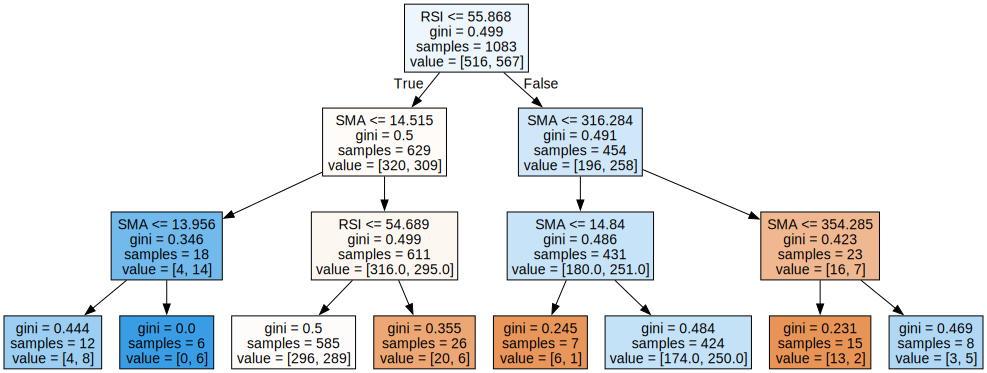

In [19]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(
    clf, out_file=None, filled=True, feature_names=predictors_list)
graphviz.Source(dot_data)

In [20]:
y_pred = clf.predict(X_test)

In [21]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.73      0.60       126
           1       0.61      0.37      0.46       145

    accuracy                           0.54       271
   macro avg       0.56      0.55      0.53       271
weighted avg       0.56      0.54      0.52       271



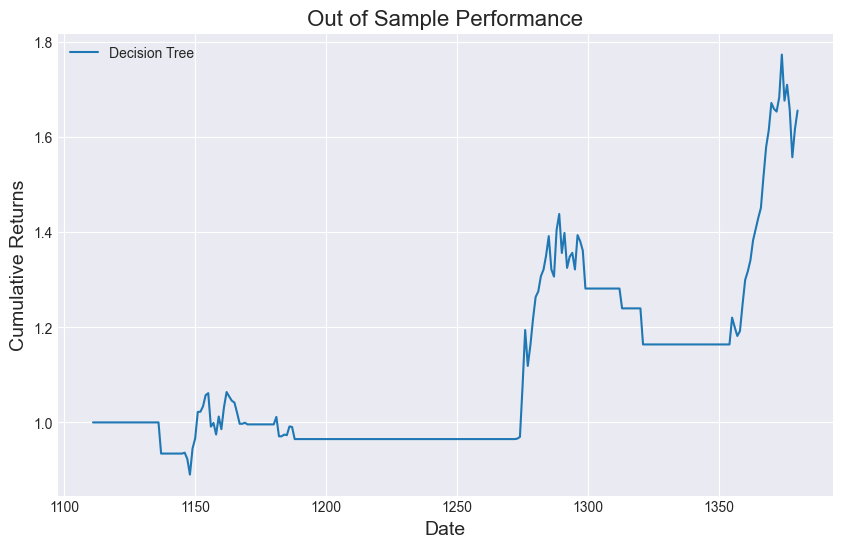

In [22]:
# Store the test dataset in new dataframe df_split
df_split = df[split:]

# Store the decision tree's predicted output to signal column of df_split dataframe
df_split["signal"] = y_pred

# Calculate the strategy returns by multiplying the percentage change in the "CLOSE" column
# with the lagged values of the "signal" column and assigns it to a new column "Strategy returns"
df_split["Strategy returns"] = df_split["CLOSE"].pct_change() * \
    df_split["signal"].shift(1)

# Import the required matplotlib library for plotting and sets the style of the plots
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Plot the cumulative product of the strategy returns + 1 over time as a line plot
# with the label 'Decision Tree' for the legend and sets the size of the figure to (15, 7)
(df_split['Strategy returns'] +
 1).cumprod().plot(label='Decision Tree', figsize=(10, 6))

# Set the title of the plot to 'Out of Sample Performance' with a font size of 16
plt.title('Out of Sample Performance', fontsize=16)

# Set the labels for the x and y axes as 'Date' and 'Cumulative Returns' respectively
# with font sizes of 14
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)

# Display the legend on the plot
plt.legend()

# Show the plot on the output screen
plt.show()